# TASK TWO

# TIER A (THE STATISCIAN)/ XGBOOST MODEL

## STEP 1: IMPORT LIBRARIES AND SETUP

In [1]:
# Import required libraries
import os
import json
import re
import warnings
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ All libraries imported successfully")
print("  - pandas, numpy, matplotlib, seaborn")
print("  - scikit-learn (metrics, model_selection)")
print("  - xgboost")
print(f"  - XGBoost version: {xgb.__version__}")

✓ All libraries imported successfully
  - pandas, numpy, matplotlib, seaborn
  - scikit-learn (metrics, model_selection)
  - xgboost
  - XGBoost version: 3.1.3


## STEP 2: LOAD AND PREPARE FEATURE DATA

We'll extract all the linguistic features computed in Task 1 for both Class 1 (human-written) and Class 2 (AI-generated) texts.

In [2]:
# Import helper functions from Task 1
import spacy

# Function to extract words from text
def extract_words(text):
    """Extract words from text (lowercase, alphanumeric only)"""
    words = re.findall(r'\b[a-z]+\b', text.lower())
    return words

# Function to calculate Type-Token Ratio (TTR)
def calculate_ttr(text):
    """Calculate Type-Token Ratio (TTR)"""
    words = extract_words(text)
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# Function to calculate Hapax Legomena
def calculate_hapax(text, sample_size=5000):
    """Calculate Hapax Legomena count"""
    words = extract_words(text)
    sample_words = words[:sample_size]
    if len(sample_words) == 0:
        return 0
    word_counts = Counter(sample_words)
    return sum(1 for count in word_counts.values() if count == 1)

# Load spaCy model for POS tagging and syntactic analysis
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy model loaded successfully")
except:
    print("⚠ spaCy model not found. Please install it.")
    print("  Run: python -m spacy download en_core_web_sm")

✓ spaCy model loaded successfully


In [3]:
def extract_all_features(text, label_name=""):
    """
    Extract all linguistic features from a text sample.
    Returns a dictionary with all features used for classification.
    """
    features = {'text_label': label_name}
    
    # 1. LEXICAL RICHNESS FEATURES
    words = extract_words(text)
    total_words = len(words)
    unique_words = len(set(words))
    
    features['total_words'] = total_words
    features['unique_words'] = unique_words
    features['ttr'] = calculate_ttr(text)
    features['hapax_legomena'] = calculate_hapax(text, sample_size=5000)
    
    # 2. PUNCTUATION DENSITY (per 1000 words)
    if total_words > 0:
        factor = 1000 / total_words
        features['semicolon_density'] = text.count(';') * factor
        features['em_dash_density'] = (text.count('—') + text.count('--')) * factor
        features['exclamation_density'] = text.count('!') * factor
        features['comma_density'] = text.count(',') * factor
        features['period_density'] = text.count('.') * factor
    else:
        features['semicolon_density'] = 0
        features['em_dash_density'] = 0
        features['exclamation_density'] = 0
        features['comma_density'] = 0
        features['period_density'] = 0
    
    # 3. SYNTACTIC COMPLEXITY & POS FEATURES
    doc = nlp(text[:1000000])  # Limit to 1M chars
    sentences = list(doc.sents)
    
    # Average sentence length
    if len(sentences) > 0:
        total_sent_words = sum(len([t for t in sent if not t.is_punct]) for sent in sentences)
        features['avg_sentence_length'] = total_sent_words / len(sentences)
    else:
        features['avg_sentence_length'] = 0
    
    # Dependency tree depth (sample of 100 sentences)
    def get_tree_depth(token, depth=0):
        if not list(token.children):
            return depth
        return max(get_tree_depth(child, depth + 1) for child in token.children)
    
    sample_sentences = sentences[:100]
    depths = [get_tree_depth(sent.root) for sent in sample_sentences if sent.root]
    features['avg_dependency_depth'] = np.mean(depths) if depths else 0
    
    # POS tag distribution
    pos_counts = Counter([token.pos_ for token in doc if not token.is_punct and not token.is_space])
    total_pos = sum(pos_counts.values())
    
    if total_pos > 0:
        features['noun_ratio'] = (pos_counts['NOUN'] + pos_counts['PROPN']) / total_pos
        features['verb_ratio'] = pos_counts['VERB'] / total_pos
        features['adj_ratio'] = pos_counts['ADJ'] / total_pos
        features['adv_ratio'] = pos_counts['ADV'] / total_pos
        features['adj_to_noun_ratio'] = features['adj_ratio'] / features['noun_ratio'] if features['noun_ratio'] > 0 else 0
    else:
        features['noun_ratio'] = 0
        features['verb_ratio'] = 0
        features['adj_ratio'] = 0
        features['adv_ratio'] = 0
        features['adj_to_noun_ratio'] = 0
    
    # 4. READABILITY INDEX (Flesch-Kincaid Grade Level)
    sentences_text = re.split(r'[.!?]+', text)
    sentences_text = [s.strip() for s in sentences_text if s.strip()]
    total_sentences = len(sentences_text)
    
    if total_sentences > 0 and total_words > 0:
        # Count syllables
        def count_syllables(word):
            word = word.lower()
            vowels = 'aeiouy'
            syllable_count = 0
            previous_was_vowel = False
            
            for char in word:
                is_vowel = char in vowels
                if is_vowel and not previous_was_vowel:
                    syllable_count += 1
                previous_was_vowel = is_vowel
            
            if word.endswith('e'):
                syllable_count -= 1
            if syllable_count == 0:
                syllable_count = 1
            return syllable_count
        
        total_syllables = sum(count_syllables(word) for word in words)
        avg_words_per_sentence = total_words / total_sentences
        avg_syllables_per_word = total_syllables / total_words
        
        features['fk_grade_level'] = 0.39 * avg_words_per_sentence + 11.8 * avg_syllables_per_word - 15.59
        features['avg_syllables_per_word'] = avg_syllables_per_word
    else:
        features['fk_grade_level'] = 0
        features['avg_syllables_per_word'] = 0
    
    return features

print("✓ Feature extraction function loaded successfully")
print("  Features extracted: lexical richness, punctuation, POS, syntax, readability")

✓ Feature extraction function loaded successfully
  Features extracted: lexical richness, punctuation, POS, syntax, readability


## STEP 3: DATA PREPROCESSING

Prepare the feature matrix and target labels for machine learning.

In [4]:
# Define paths to the datasets
base_path_class1 = Path(r'c:\Users\eisas\OneDrive\Desktop\PROJECTS\Precog_task\output\class1')
base_path_class2 = Path(r'c:\Users\eisas\OneDrive\Desktop\PROJECTS\Precog_task\output\class2')

# Class 1: Human-written novels (cleaned texts)
class1_files = [
    ('Heart of Darkness', base_path_class1 / 'heart_of_darkness_cleaned.txt'),
    ('Lord Jim', base_path_class1 / 'lord_jim_cleaned.txt'),
    ('Metamorphosis', base_path_class1 / 'metamorphosis_cleaned.txt'),
    ('The Trial', base_path_class1 / 'the_trial_cleaned.txt'),
    ('Typhoon', base_path_class1 / 'typhoon_cleaned.txt')
]

# Class 2: AI-generated generic paragraphs
class2_files = [
    ('Heart of Darkness (AI)', base_path_class2 / 'heart_of_darkness_generic.jsonl'),
    ('Lord Jim (AI)', base_path_class2 / 'lord_jim_generic.jsonl'),
    ('Metamorphosis (AI)', base_path_class2 / 'metamorphosis_generic.jsonl'),
    ('The Trial (AI)', base_path_class2 / 'the_trial_generic.jsonl'),
    ('Typhoon (AI)', base_path_class2 / 'typhoon_generic.jsonl')
]

print("✓ Dataset paths configured")
print(f"  - Class 1 (Human): {len(class1_files)} novels")
print(f"  - Class 2 (AI): {len(class2_files)} generated texts")

✓ Dataset paths configured
  - Class 1 (Human): 5 novels
  - Class 2 (AI): 5 generated texts


In [5]:
# Function to chunk text into ~1000 word segments
def chunk_text(text, chunk_size=1000):
    """Split text into chunks of approximately chunk_size words"""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) >= 500:  # Only include chunks with at least 500 words
            chunks.append(chunk)
    return chunks

# Load and extract features from all texts
print("="*70)
print("EXTRACTING FEATURES FROM ALL TEXTS (CHUNKED)")
print("="*70)

all_features = []

# Process Class 1 (Human-written texts) - CHUNK INTO ~1000 WORD SEGMENTS
print("\n Processing Class 1 (Human-written)...")
for novel_name, filepath in class1_files:
    print(f"  - Loading {novel_name}...")
    text = filepath.read_text(encoding='utf-8')
    
    # Chunk the text into ~1000 word segments
    chunks = chunk_text(text, chunk_size=1000)
    print(f"    Created {len(chunks)} chunks")
    
    # Extract features for each chunk
    for idx, chunk in enumerate(chunks):
        features = extract_all_features(chunk, label_name=f"{novel_name}_chunk_{idx+1}")
        features['class'] = 0  # Class 1 = 0 (Human)
        features['source_novel'] = novel_name
        all_features.append(features)
    
    print(f"    ✓ Extracted features from {len(chunks)} chunks")

# Process Class 2 (AI-generated texts) - EACH PARAGRAPH SEPARATELY
print("\n Processing Class 2 (AI-generated)...")
for novel_name, filepath in class2_files:
    print(f"  - Loading {novel_name}...")
    
    # Load JSONL file - each paragraph separately
    paragraph_count = 0
    with filepath.open('r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                entry = json.loads(line)
                paragraph_text = entry['text']
                
                # Extract features for each paragraph
                features = extract_all_features(paragraph_text, label_name=f"{novel_name}_para_{paragraph_count+1}")
                features['class'] = 1  # Class 2 = 1 (AI)
                features['source_novel'] = novel_name
                all_features.append(features)
                paragraph_count += 1
    
    print(f"    ✓ Extracted features from {paragraph_count} paragraphs")

print("\n" + "="*70)
print(f"✓ FEATURE EXTRACTION COMPLETE")
print(f"  Total samples: {len(all_features)}")
print(f"  Class 0 (Human chunks): {sum(1 for f in all_features if f['class'] == 0)}")
print(f"  Class 1 (AI paragraphs): {sum(1 for f in all_features if f['class'] == 1)}")
print("="*70)

EXTRACTING FEATURES FROM ALL TEXTS (CHUNKED)

 Processing Class 1 (Human-written)...
  - Loading Heart of Darkness...
    Created 39 chunks
    ✓ Extracted features from 39 chunks
  - Loading Lord Jim...
    Created 129 chunks
    ✓ Extracted features from 129 chunks
  - Loading Metamorphosis...
    Created 22 chunks
    ✓ Extracted features from 22 chunks
  - Loading The Trial...
    Created 84 chunks
    ✓ Extracted features from 84 chunks
  - Loading Typhoon...
    Created 30 chunks
    ✓ Extracted features from 30 chunks

 Processing Class 2 (AI-generated)...
  - Loading Heart of Darkness (AI)...
    ✓ Extracted features from 500 paragraphs
  - Loading Lord Jim (AI)...
    ✓ Extracted features from 500 paragraphs
  - Loading Metamorphosis (AI)...
    ✓ Extracted features from 500 paragraphs
  - Loading The Trial (AI)...
    ✓ Extracted features from 500 paragraphs
  - Loading Typhoon (AI)...
    ✓ Extracted features from 500 paragraphs

✓ FEATURE EXTRACTION COMPLETE
  Total samples

In [6]:
# Create DataFrame and shuffle
df = pd.DataFrame(all_features)

# Shuffle the dataset to mix Class 1 and Class 2 samples
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the dataset
print("="*70)
print("FEATURE DATASET OVERVIEW (SHUFFLED)")
print("="*70)
print(f"\nDataset Shape: {df.shape}")
print(f"  - Total samples: {df.shape[0]}")
print(f"  - Features: {df.shape[1] - 3}")  # Exclude 'text_label', 'class', and 'source_novel'
print(f"\nClass Distribution:")
print(df['class'].value_counts().to_string())
print(f"\nClass Balance:")
class_counts = df['class'].value_counts()
print(f"  - Class 0 (Human): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"  - Class 1 (AI): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
print(f"\nFirst few samples (after shuffling):")
print(df[['text_label', 'class', 'ttr', 'hapax_legomena', 'avg_sentence_length']].head(10))
print("\n" + "="*70)

FEATURE DATASET OVERVIEW (SHUFFLED)

Dataset Shape: (2804, 21)
  - Total samples: 2804
  - Features: 18

Class Distribution:
class
1    2500
0     304

Class Balance:
  - Class 0 (Human): 304 (10.8%)
  - Class 1 (AI): 2500 (89.2%)

First few samples (after shuffling):
                        text_label  class       ttr  hapax_legomena  \
0           Lord Jim (AI)_para_288      1  0.766667              79   
1           Lord Jim (AI)_para_238      1  0.813725              73   
2      Metamorphosis (AI)_para_218      1  0.699301              85   
3            Typhoon (AI)_para_200      1  0.719626              64   
4      Metamorphosis (AI)_para_215      1  0.686667              88   
5  Heart of Darkness (AI)_para_392      1  0.664384              79   
6                The Trial_chunk_7      0  0.379883             238   
7           Lord Jim (AI)_para_100      1  0.704000              74   
8            Typhoon (AI)_para_315      1  0.750000              64   
9            Typhoon 

In [7]:
# BALANCE THE DATASET - Downsample Class 1 to match Class 0
print("="*70)
print("BALANCING THE DATASET")
print("="*70)
print("\nOriginal dataset:")
print(f"  - Class 0 (Human): {(df['class'] == 0).sum()} samples")
print(f"  - Class 1 (AI): {(df['class'] == 1).sum()} samples")
print(f"  - Imbalance ratio: 1:{(df['class'] == 1).sum() / (df['class'] == 0).sum():.1f}")

# Separate the two classes
df_class0 = df[df['class'] == 0]
df_class1 = df[df['class'] == 1]

# Downsample Class 1 to match Class 0
# We'll take slightly more AI samples to maintain some diversity
target_size = min(len(df_class0) + 50, len(df_class1))  # +50 for slightly more AI samples
df_class1_downsampled = df_class1.sample(n=target_size, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_class0, df_class1_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced dataset:")
print(f"  - Class 0 (Human): {(df_balanced['class'] == 0).sum()} samples")
print(f"  - Class 1 (AI): {(df_balanced['class'] == 1).sum()} samples")
print(f"  - New ratio: 1:{(df_balanced['class'] == 1).sum() / (df_balanced['class'] == 0).sum():.2f}")
print(f"  - Total samples: {len(df_balanced)}")
print("\n⚠ Note: Using balanced dataset for more realistic evaluation")
print("="*70)

# Update df to use balanced dataset
df = df_balanced

BALANCING THE DATASET

Original dataset:
  - Class 0 (Human): 304 samples
  - Class 1 (AI): 2500 samples
  - Imbalance ratio: 1:8.2

Balanced dataset:
  - Class 0 (Human): 304 samples
  - Class 1 (AI): 354 samples
  - New ratio: 1:1.16
  - Total samples: 658

⚠ Note: Using balanced dataset for more realistic evaluation


In [8]:
# Separate features and target
# Drop non-numeric columns (text_label, class, source_novel)
X = df.drop(['text_label', 'class', 'source_novel'], axis=1)
y = df['class']

# ⚠ CRITICAL FIX: Remove length-based features that leak information
# Human chunks are ~1000 words, AI paragraphs are ~100 words
# These features give perfect separation and prevent learning actual linguistic patterns
print("="*70)
print("REMOVING LENGTH-BASED FEATURES")
print("="*70)
print("\n⚠ Removing features that leak text length information:")
print("  - total_words (Human: ~1000, AI: ~100)")
print("  - unique_words (correlated with total_words)")
print("\nReason: These features perfectly separate classes based on chunk size,")
print("        preventing the model from learning actual linguistic differences.")
print("="*70)

X = X.drop(['total_words', 'unique_words'], axis=1)

# Store feature names for later interpretation
feature_names = X.columns.tolist()

# Check for missing values
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)
print(f"\nMissing values per feature:")
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(missing_counts[missing_counts > 0])
    # Fill missing values with 0 (if any)
    X = X.fillna(0)
    print("\n✓ Missing values filled with 0")
else:
    print("  None - dataset is complete!")

# Ensure all features are numeric
X = X.astype(float)

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"\nFeature Names ({len(feature_names)}):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

print("\n" + "="*70)


REMOVING LENGTH-BASED FEATURES

⚠ Removing features that leak text length information:
  - total_words (Human: ~1000, AI: ~100)
  - unique_words (correlated with total_words)

Reason: These features perfectly separate classes based on chunk size,
        preventing the model from learning actual linguistic differences.

DATA PREPROCESSING

Missing values per feature:
  None - dataset is complete!

Feature Matrix Shape: (658, 16)
Target Vector Shape: (658,)

Feature Names (16):
   1. ttr
   2. hapax_legomena
   3. semicolon_density
   4. em_dash_density
   5. exclamation_density
   6. comma_density
   7. period_density
   8. avg_sentence_length
   9. avg_dependency_depth
  10. noun_ratio
  11. verb_ratio
  12. adj_ratio
  13. adv_ratio
  14. adj_to_noun_ratio
  15. fk_grade_level
  16. avg_syllables_per_word



## STEP 4: TRAIN-TEST SPLIT (NOVEL-BASED)

Split by source novel to prevent train-test leakage. Chunks from the same novel stay together.

In [9]:
# CRITICAL FIX: Split by source novel to prevent train-test leakage
# Without this, chunks from the same novel appear in both train and test,
# allowing the model to memorize novel-specific patterns

print("="*70)
print("NOVEL-BASED TRAIN-TEST SPLIT")
print("="*70)

# Get unique novels for each class
df_with_source = df.copy()
df_with_source['X_index'] = X.index  # Keep track of indices

human_novels = df_with_source[df_with_source['class'] == 0]['source_novel'].unique()
ai_novels = df_with_source[df_with_source['class'] == 1]['source_novel'].unique()

print(f"\nHuman novels: {list(human_novels)}")
print(f"AI novels: {list(ai_novels)}")

# Split novels (not chunks) into train/test
# Use 4 novels for training, 1 for testing from each class
from sklearn.model_selection import train_test_split as tts
human_train_novels, human_test_novels = tts(human_novels, test_size=0.2, random_state=42)
ai_train_novels, ai_test_novels = tts(ai_novels, test_size=0.2, random_state=42)

print(f"\nTrain novels (Human): {list(human_train_novels)}")
print(f"Test novels (Human): {list(human_test_novels)}")
print(f"Train novels (AI): {list(ai_train_novels)}")
print(f"Test novels (AI): {list(ai_test_novels)}")

# Create train/test indices based on novel membership
train_mask = df_with_source['source_novel'].isin(list(human_train_novels) + list(ai_train_novels))
test_mask = ~train_mask

# Split data
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\nTraining Set:")
print(f"  - Samples: {X_train.shape[0]}")
print(f"  - Class 0 (Human): {(y_train == 0).sum()}")
print(f"  - Class 1 (AI): {(y_train == 1).sum()}")

print(f"\nTest Set:")
print(f"  - Samples: {X_test.shape[0]}")
print(f"  - Class 0 (Human): {(y_test == 0).sum()}")
print(f"  - Class 1 (AI): {(y_test == 1).sum()}")

print("\n⚠ Note: Novels are completely separated between train/test to prevent leakage")
print("="*70)

NOVEL-BASED TRAIN-TEST SPLIT

Human novels: ['The Trial', 'Lord Jim', 'Heart of Darkness', 'Typhoon', 'Metamorphosis']
AI novels: ['Lord Jim (AI)', 'The Trial (AI)', 'Metamorphosis (AI)', 'Heart of Darkness (AI)', 'Typhoon (AI)']

Train novels (Human): ['Metamorphosis', 'Heart of Darkness', 'The Trial', 'Typhoon']
Test novels (Human): ['Lord Jim']
Train novels (AI): ['Typhoon (AI)', 'Metamorphosis (AI)', 'Lord Jim (AI)', 'Heart of Darkness (AI)']
Test novels (AI): ['The Trial (AI)']

Training Set:
  - Samples: 447
  - Class 0 (Human): 175
  - Class 1 (AI): 272

Test Set:
  - Samples: 211
  - Class 0 (Human): 129
  - Class 1 (AI): 82

⚠ Note: Novels are completely separated between train/test to prevent leakage


## STEP 5: FEATURE NORMALIZATION (AFTER SPLIT)

⚠ **CRITICAL:** Normalize AFTER splitting to prevent data leakage. The scaler must only learn from training data.

In [10]:
from sklearn.preprocessing import StandardScaler

# ⚠ CRITICAL: Normalize AFTER train-test split to prevent data leakage
# The scaler must ONLY learn statistics from the training data
print("="*70)
print("FEATURE NORMALIZATION (AFTER SPLIT)")
print("="*70)

scaler = StandardScaler()

# Fit scaler on TRAINING data only
scaler.fit(X_train)

# Transform both train and test using the fitted scaler
X_train_normalized = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_normalized = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n✓ Features normalized using StandardScaler")
print("  - Scaler fitted on TRAINING data only")
print("  - Applied to both train and test sets")
print("  - Mean: 0, Std Dev: 1 (based on training data)")

print(f"\nTraining set shape: {X_train_normalized.shape}")
print(f"Test set shape: {X_test_normalized.shape}")

print("\nSample statistics (first 5 features, training set):")
print(X_train_normalized.iloc[:, :5].describe())
print("\n" + "="*70)

# Update X_train and X_test to use normalized features
X_train = X_train_normalized
X_test = X_test_normalized

FEATURE NORMALIZATION (AFTER SPLIT)

✓ Features normalized using StandardScaler
  - Scaler fitted on TRAINING data only
  - Applied to both train and test sets
  - Mean: 0, Std Dev: 1 (based on training data)

Training set shape: (447, 16)
Test set shape: (211, 16)

Sample statistics (first 5 features, training set):
                ttr  hapax_legomena  semicolon_density  em_dash_density  \
count  4.470000e+02    4.470000e+02       4.470000e+02     4.470000e+02   
mean  -7.004092e-16   -1.072967e-16       1.887628e-17    -1.192186e-17   
std    1.001120e+00    1.001120e+00       1.001120e+00     1.001120e+00   
min   -1.943461e+00   -1.081560e+00      -6.819244e-01    -4.457625e-01   
25%   -1.068828e+00   -7.678873e-01      -6.819244e-01    -4.457625e-01   
50%    4.439010e-01   -6.306557e-01      -6.819244e-01    -4.457625e-01   
75%    8.100499e-01    8.347817e-01       7.240925e-01    -1.463956e-01   
max    1.706527e+00    2.496264e+00       4.209594e+00     5.588034e+00   

     

## STEP 6: TRAIN XGBOOST CLASSIFIER

Train an XGBoost model using the engineered linguistic features.

In [11]:
# Calculate class weight to handle any remaining imbalance
# scale_pos_weight = count(negative class) / count(positive class)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("="*70)
print("CLASS IMBALANCE HANDLING")
print("="*70)
print(f"Class 0 (Human): {(y_train == 0).sum()} samples")
print(f"Class 1 (AI): {(y_train == 1).sum()} samples")
print(f"Imbalance ratio: 1:{(y_train == 1).sum() / (y_train == 0).sum():.2f}")
print(f"scale_pos_weight: {scale_pos_weight:.4f}")
print("="*70)

# Initialize XGBoost Classifier with class weighting
model = xgb.XGBClassifier(
    n_estimators=100,           # Number of boosting rounds
    max_depth=3,                # Maximum tree depth
    learning_rate=0.1,          # Step size shrinkage
    objective='binary:logistic', # Binary classification
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss'
)

print("\n" + "="*70)
print("TRAINING XGBOOST CLASSIFIER")
print("="*70)
print("\nModel Configuration:")
print(f"  - Algorithm: XGBoost")
print(f"  - Number of estimators: {model.n_estimators}")
print(f"  - Max depth: {model.max_depth}")
print(f"  - Learning rate: {model.learning_rate}")
print(f"  - Objective: {model.objective}")
print(f"  - scale_pos_weight: {model.scale_pos_weight:.4f} (to handle imbalance)")

print("\n Training model...")
model.fit(X_train, y_train)

print("✓ Training complete!")
print("="*70)

CLASS IMBALANCE HANDLING
Class 0 (Human): 175 samples
Class 1 (AI): 272 samples
Imbalance ratio: 1:1.55
scale_pos_weight: 0.6434

TRAINING XGBOOST CLASSIFIER

Model Configuration:
  - Algorithm: XGBoost
  - Number of estimators: 100
  - Max depth: 3
  - Learning rate: 0.1
  - Objective: binary:logistic
  - scale_pos_weight: 0.6434 (to handle imbalance)

 Training model...
✓ Training complete!


## STEP 7: MODEL EVALUATION

Evaluate the model's performance on both training and test sets.

In [13]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Get prediction probabilities for ROC-AUC
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='binary'
)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='binary'
)

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Display results
print("="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)

print("\n TRAINING SET PERFORMANCE:")
print(f"  - Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  - Precision: {train_precision:.4f}")
print(f"  - Recall:    {train_recall:.4f}")
print(f"  - F1-Score:  {train_f1:.4f}")
print(f"  - ROC-AUC:   {train_auc:.4f}")

print("\n TEST SET PERFORMANCE:")
print(f"  - Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")
print(f"  - ROC-AUC:   {test_auc:.4f}")

print("\n" + "="*70)

MODEL PERFORMANCE METRICS

 TRAINING SET PERFORMANCE:
  - Accuracy:  1.0000 (100.00%)
  - Precision: 1.0000
  - Recall:    1.0000
  - F1-Score:  1.0000
  - ROC-AUC:   1.0000

 TEST SET PERFORMANCE:
  - Accuracy:  1.0000 (100.00%)
  - Precision: 1.0000
  - Recall:    1.0000
  - F1-Score:  1.0000
  - ROC-AUC:   1.0000



In [14]:
# Detailed classification report
print("="*70)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*70)
print("\nClass Labels:")
print("  0 = Human-written (Class 1)")
print("  1 = AI-generated (Class 2)")
print("\n" + classification_report(y_test, y_test_pred, target_names=['Human', 'AI']))
print("="*70)

DETAILED CLASSIFICATION REPORT (Test Set)

Class Labels:
  0 = Human-written (Class 1)
  1 = AI-generated (Class 2)

              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       129
          AI       1.00      1.00      1.00        82

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



## STEP 8: CONFUSION MATRIX VISUALIZATION

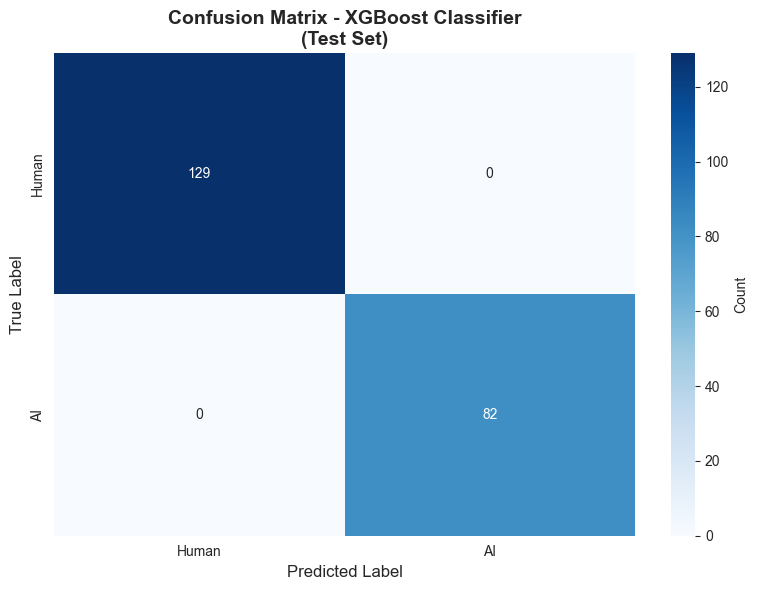

CONFUSION MATRIX INTERPRETATION

True Negatives (TN):  129 - Correctly identified as Human
False Positives (FP): 0 - Human misclassified as AI
False Negatives (FN): 0 - AI misclassified as Human
True Positives (TP):  82 - Correctly identified as AI



In [15]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_title('Confusion Matrix - XGBoost Classifier\n(Test Set)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("="*70)
print("CONFUSION MATRIX INTERPRETATION")
print("="*70)
print(f"\nTrue Negatives (TN):  {cm[0,0]} - Correctly identified as Human")
print(f"False Positives (FP): {cm[0,1]} - Human misclassified as AI")
print(f"False Negatives (FN): {cm[1,0]} - AI misclassified as Human")
print(f"True Positives (TP):  {cm[1,1]} - Correctly identified as AI")
print("\n" + "="*70)

## STEP 9: FEATURE IMPORTANCE ANALYSIS

Analyze which linguistic features contribute most to the classification decision.

In [16]:
# Extract feature importance from the model
feature_importance = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Display top features
print("="*70)
print("FEATURE IMPORTANCE RANKING")
print("="*70)
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))
print("\n" + "="*70)

FEATURE IMPORTANCE RANKING

Top 10 Most Important Features:
             Feature  Importance
      hapax_legomena         1.0
                 ttr         0.0
   semicolon_density         0.0
     em_dash_density         0.0
 exclamation_density         0.0
       comma_density         0.0
      period_density         0.0
 avg_sentence_length         0.0
avg_dependency_depth         0.0
          noun_ratio         0.0



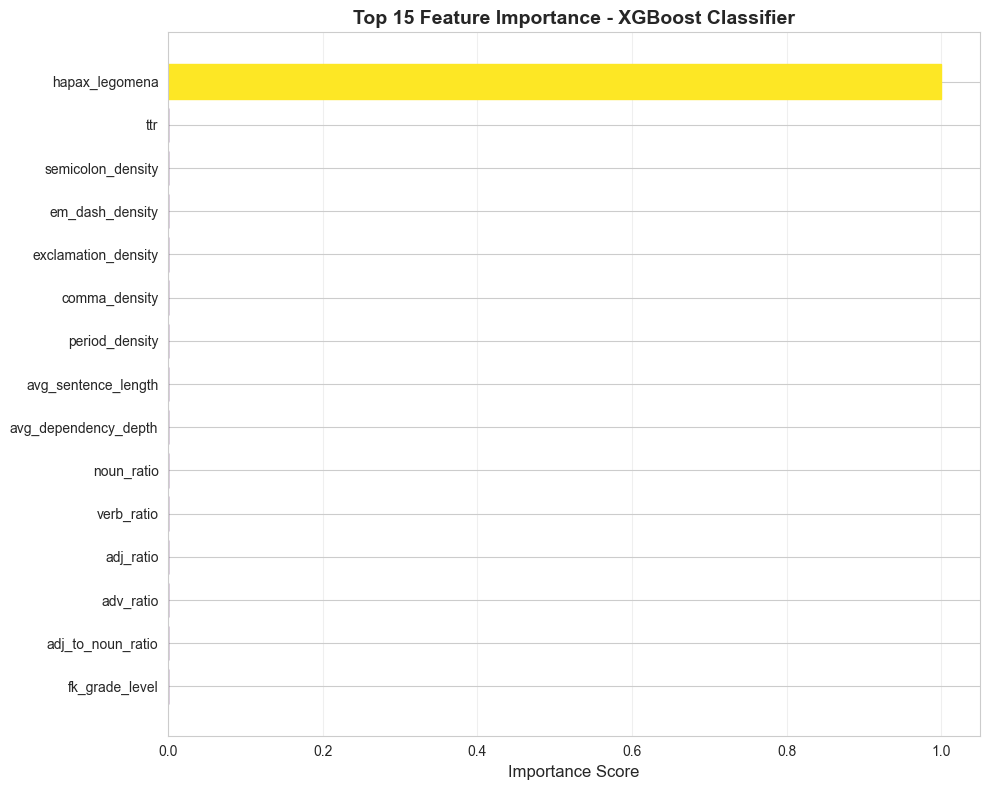

In [17]:
# Visualize feature importance (top 15 features)
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = importance_df.head(top_n)

bars = ax.barh(range(top_n), top_features['Importance'].values)

# Color bars by importance
colors = plt.cm.viridis(top_features['Importance'].values / top_features['Importance'].values.max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importance - XGBoost Classifier', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## STEP 10: ROC CURVE ANALYSIS

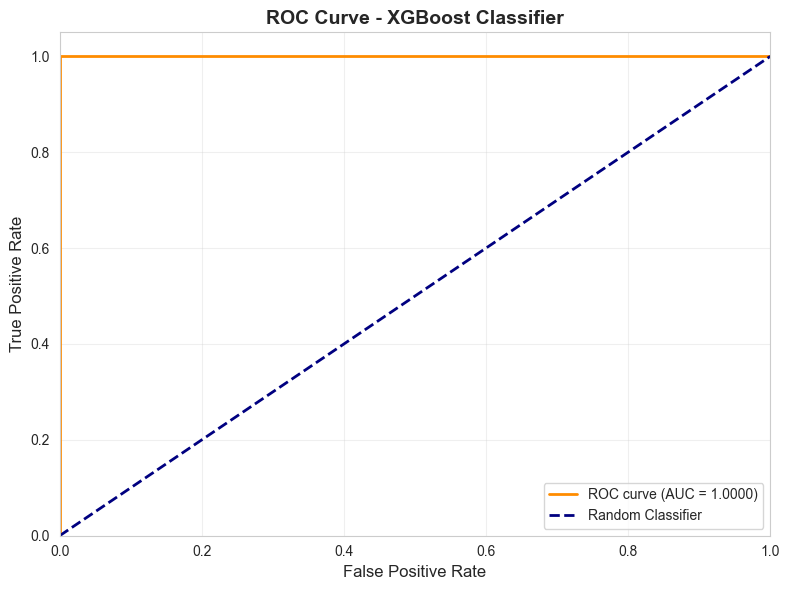

ROC-AUC SCORE INTERPRETATION

ROC-AUC Score: 1.0000

Interpretation:
  ✓ Excellent discrimination (0.9-1.0)



In [18]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - XGBoost Classifier', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
print("ROC-AUC SCORE INTERPRETATION")
print("="*70)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
print("\nInterpretation:")
if roc_auc >= 0.9:
    print("  ✓ Excellent discrimination (0.9-1.0)")
elif roc_auc >= 0.8:
    print("  ✓ Good discrimination (0.8-0.9)")
elif roc_auc >= 0.7:
    print("  ⚠ Acceptable discrimination (0.7-0.8)")
else:
    print("  ⚠ Poor discrimination (<0.7)")
print("\n" + "="*70)